In [1]:
%load_ext autoreload
%autoreload 2

# LOCAL
# PROJECT_PATH = '/Users/ivan_zorin/Documents/DEV/code/ntl/'
# DATA_PATH = '/Users/ivan_zorin/Documents/DEV/data/sgcc/data.csv'
# LOG_DIR = '/Users/ivan_zorin/Documents/DEV/runs/debug/trainer'

# ZHORES
PROJECT_PATH = '/trinity/home/ivan.zorin/dev/code/ntl/'
DATA_PATH = '/trinity/home/ivan.zorin/dev/data/sgcc/data.csv'
LOG_DIR = '/trinity/home/ivan.zorin/dev/logs/debug/one-batch/'

In [4]:
import numpy as np 
from numpy import ndarray
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, robust_scale
from sktime.transformations.series.impute import Imputer

from functools import partial
from types import SimpleNamespace

from tqdm.auto import tqdm


import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import sys
sys.path.append(PROJECT_PATH)
from ntl.data import SGCCDataset, data_train_test_split
from ntl.data import FillNA, Scale, Reshape, ToTensor, Cutout, Diff
from ntl.models import AE2dCNN
from ntl.trainer import ArgsTrainer
from ntl.utils import fix_seed

In [ ]:
fix_seed(42)

transforms = [FillNA('drift'), 
            Cutout(256), 
            Scale('minmax'), 
            Reshape((16, 16)),
            lambda x: x[None],
            ToTensor()
]
normal_data = SGCCDataset(DATA_PATH, label=0, nan_ratio=0.75, transforms=transforms, year=2016)
anomal_data = SGCCDataset(DATA_PATH, label=1, nan_ratio=1.0, transforms=transforms, year=2016)

train, test = data_train_test_split(normal_data, anomal_data)

train_loader = DataLoader(train, batch_size=64, drop_last=False, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)


### one batch over-fit

In [ ]:
batch_size = 64
one_batch_idxs = np.random.randint(0, len(normal_data), batch_size)
loader = DataLoader(torch.utils.data.Subset(normal_data, one_batch_idxs), batch_size=batch_size)

In [ ]:
model = AE2dCNN()
loss = nn.MSELoss(reduction='none')
optim = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=2)
logger = SummaryWriter(log_dir=LOG_DIR) 

config = SimpleNamespace(**{
    'debug': True,
    'n_debug_batches': 1,
    'log_step': 5,
    'n_epochs': 100
})


trainer = ArgsTrainer(
    train_loader=loader,
    val_loader=loader,
    model=model,
    loss=loss,
    optim=optim,
    scheduler=scheduler,
    config=config,
    logger=logger
)


In [ ]:
losses = []
for epoch in tqdm(range(100)):
    train_loss = trainer.train_step(epoch)
    trainer.logger.add_scalars('loss', {'train': train_loss}, epoch)
    losses.append(train_loss.item())

In [ ]:
plt.figure()
plt.plot(losses)
plt.show()

In [ ]:
for sample in train:
    x = sample[1]
    emb, x_hat = trainer.model(x.to(trainer.device))

    x = x.flatten().numpy().squeeze()
    x_hat = x_hat.detach().flatten().cpu().numpy().squeeze()
    plt.figure()
    plt.plot(x, 'b--')
    plt.plot(x_hat, 'r')
    plt.show()

In [ ]:
for i, sample in enumerate(train):
    x = sample[1].flatten().numpy().squeeze()
    plt.figure()
    plt.plot(np.diff(x, n=1))
    plt.title(i)
    plt.show()
    

#### check average values of normalized inputs

In [ ]:
transforms = [FillNA('drift'), 
            Cutout(256), 
            Scale('minmax'), 
            # Reshape((16, 16)),
            # lambda x: x[None],
            # ToTensor()
]
normal_data = SGCCDataset(DATA_PATH, label=0, nan_ratio=0.75, transforms=transforms, year=2016)
anomal_data = SGCCDataset(DATA_PATH, label=1, nan_ratio=1.0, transforms=transforms, year=2016)

train, test = data_train_test_split(normal_data, anomal_data)

In [ ]:
max_values, min_values, mean_values, median_values = [], [], [], []
for sample in tqdm(train):
    x = sample[1]
    max_values.append(x.max())
    min_values.append(x.min())
    mean_values.append(x.mean())
    median_values.append(np.median(x))
    

In [ ]:
def plot_hist(data, title=''):
    plt.figure()
    plt.hist(data, density=True)
    plt.title(title)
    plt.show()
    


In [ ]:
# plot_hist(max_values, 'max_values')
# plot_hist(min_values, 'min_values')
plot_hist(mean_values, 'mean_values')
# plot_hist(median_values, 'median_values')


In [ ]:
idx = 10
sample = train[idx][1]
print(sample.mean())

plt.figure()
plt.plot(sample)
plt.show()


### Transformations 

In [5]:
transforms = [
    FillNA('drift'), 
    # Cutout(256), 
    # Scale('minmax'), 
    # Reshape((16, 16)),
    # lambda x: x[None],
    # ToTensor()
]
data = SGCCDataset(DATA_PATH, label=0, nan_ratio=0.75, transforms=transforms, year=2016)

In [13]:
diff_tr = Diff(1)
scale_tr = Scale('minmax')

In [10]:
idx = np.random.randint(0, len(data))
x = data[idx][1]

In [14]:
x1 = diff_tr(scale_tr(x))
x2 = scale_tr(diff_tr(x))

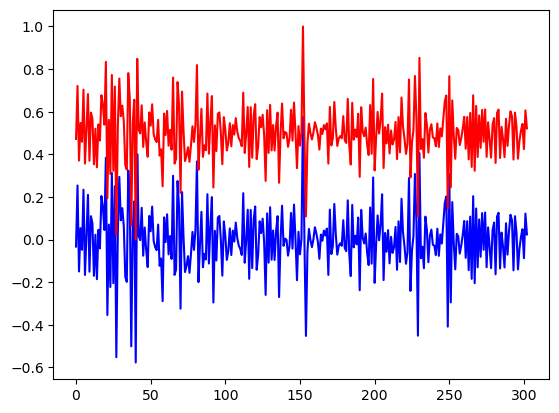

In [15]:
plt.figure()
plt.plot(x1, 'b', label='x1')
plt.plot(x2, 'r', label='x2')
plt.show()


* normalize data to 0,1 scale | check
* fill nans | check
* cut-out some piece | check
* reshape into matrix (7x52, square, other?) | check
* use this matrix as input into AE | check


Two ways of transformation 
The first one 
1. cut-out some piece
2. fill na
3. scale 
4. reshape

The second one 
1. fill na
2. scale
3. cut-out some piece
5. reshape

**#TODO**

* add x and x_hat plots
